In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import MobileNetV2
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import functools
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# Display Image Function
def display_batch(generator, class_labels, num_columns=4):
    images_batch, labels_batch = next(generator)
    label_names = {v: k for k, v in class_labels.items()}
    num_images = images_batch.shape[0]
    num_rows = num_images // num_columns + int(num_images % num_columns > 0)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(num_images):
        img = np.clip(images_batch[i], 0, 1)  # Clip the image data to the range [0, 1]
        axes[i].imshow(img)
        label_index = np.argmax(labels_batch[i])
        axes[i].set_title(label_names[label_index])
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()



# Loading Trash Dataset

In [ ]:
# Upload the trash.zip dataset to the runtime first
!unzip /content/trash.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/trash/valid/metal/._metal540.jpg  
  inflating: trash/valid/metal/metal226.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal226.jpg  
  inflating: trash/valid/metal/metal232.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal232.jpg  
  inflating: trash/valid/metal/metal554.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal554.jpg  
  inflating: trash/valid/metal/metal568.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal568.jpg  
  inflating: trash/valid/metal/metal583.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal583.jpg  
  inflating: trash/valid/metal/metal597.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal597.jpg  
  inflating: trash/valid/metal/metal571.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal571.jpg  
  inflating: trash/valid/metal/metal217.jpg  
  inflating: __MACOSX/trash/valid/metal/._metal217.jpg  
  inflating: trash/valid/metal/metal203.jpg  
  inflating: __MACOSX/

In [ ]:
import os

def count_images(folder, extensions=("jpg", "jpeg", "png", "bmp", "tiff", "gif")):
    count = 0
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(extensions):
                count += 1
    return count

train_data_dir = "/content/trash/train"
image_count = count_images(train_data_dir)
print(f"There are {image_count} images in the folder '{train_data_dir}' and its subfolders.")


test_data_dir = "/content/trash/test"
image_count = count_images(test_data_dir)
print(f"There are {image_count} images in the folder '{test_data_dir}' and its subfolders.")


There are 2019 images in the folder '/content/trash/train' and its subfolders.
There are 508 images in the folder '/content/trash/test' and its subfolders.


In [ ]:
# Re-scaled dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = "/content/trash/train"
test_data_dir = "/content/trash/test"

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Model without Augmentation


In [ ]:
# Apply the MobileNetV2 pretrained model
pretrained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# define the model
def model_1():

    model = Sequential()
    model.add(pretrained_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6))
    model.add(Activation('softmax'))

    for layer in pretrained_model.layers:
        layer.trainable = False


    model.compile(loss='categorical_crossentropy', metrics=['accuracy', top3_acc],
                  optimizer=Adam(learning_rate=0.0001, decay=1e-6))

    return model

# Test function
model_1().summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                           

In [ ]:
batch_size = 128
epochs = 15

# Do random training data augmentation with large batch size
# TODO: Augmentation / No Augmentation here
# TODO: Different backbones need different scaling
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data parameters
num_train_samples = 2019
num_test_samples = 508
# num_train_samples = 500
# num_test_samples = 500

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


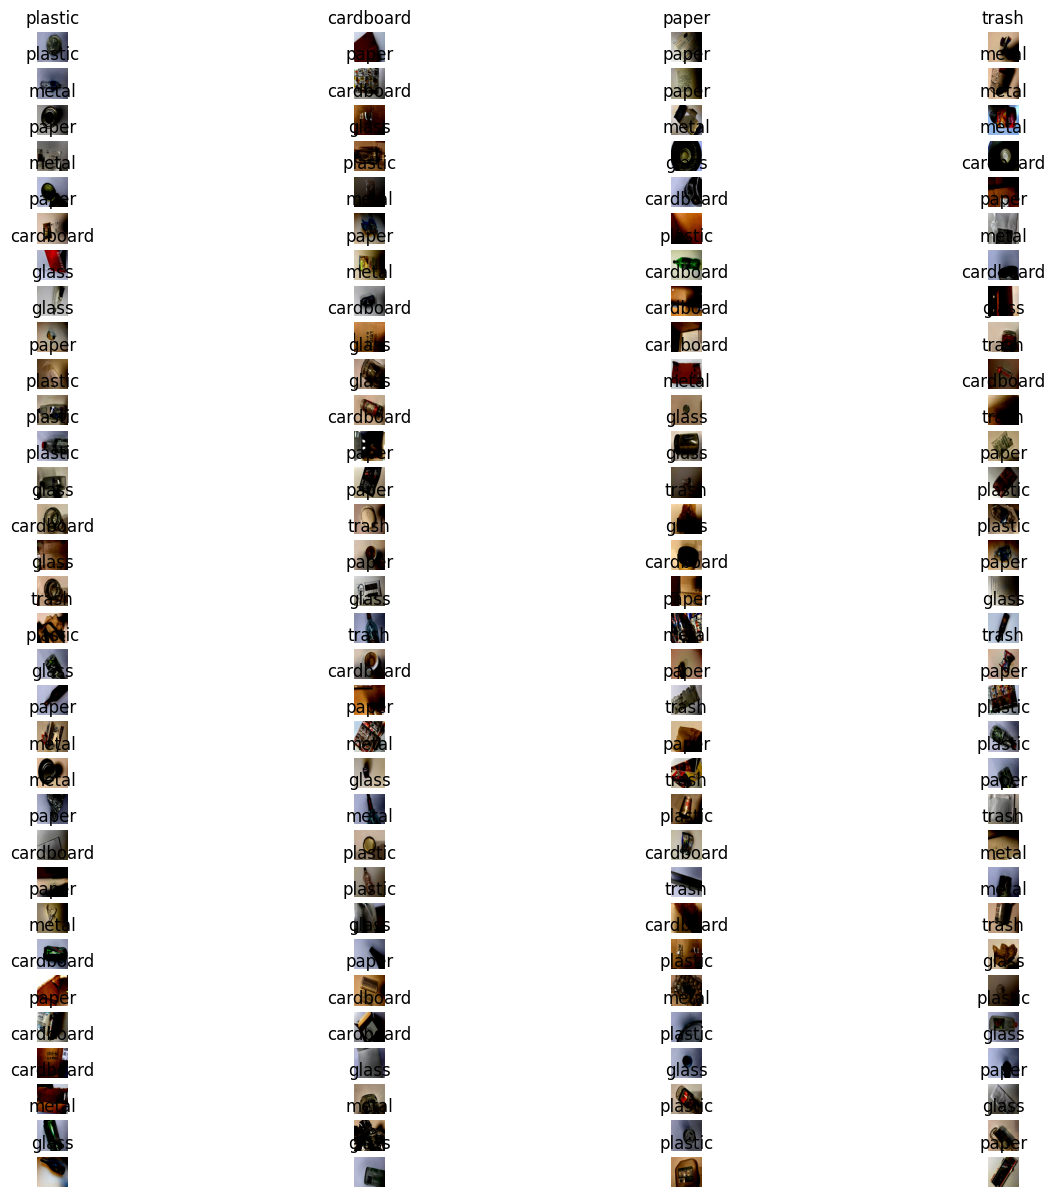

In [ ]:
# Display the training images
display_batch(train_generator, train_generator.class_indices)

In [ ]:
# Display the testing images
display_batch(test_generator, test_generator.class_indices)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model = model_1()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    steps_per_epoch=num_train_samples // batch_size,
    verbose=1,
    callbacks=early_stopping
)

Epoch 1/15
15/15 [==============================] - 20s 670ms/step - loss: 2.0499 - accuracy: 0.2015 - top3_acc: 0.5368 - val_loss: 1.7125 - val_accuracy: 0.2913 - val_top3_acc: 0.6909
Epoch 2/15
15/15 [==============================] - 9s 590ms/step - loss: 1.5589 - accuracy: 0.3665 - top3_acc: 0.7462 - val_loss: 1.4666 - val_accuracy: 0.4449 - val_top3_acc: 0.8228
Epoch 3/15
15/15 [==============================] - 9s 594ms/step - loss: 1.3748 - accuracy: 0.4802 - top3_acc: 0.8435 - val_loss: 1.2949 - val_accuracy: 0.5413 - val_top3_acc: 0.8661
Epoch 4/15
15/15 [==============================] - 9s 603ms/step - loss: 1.2187 - accuracy: 0.5738 - top3_acc: 0.8752 - val_loss: 1.1596 - val_accuracy: 0.5984 - val_top3_acc: 0.8878
Epoch 5/15
15/15 [==============================] - 9s 598ms/step - loss: 1.0879 - accuracy: 0.6267 - top3_acc: 0.9112 - val_loss: 1.0541 - val_accuracy: 0.6299 - val_top3_acc: 0.9094
Epoch 6/15
15/15 [==============================] - 9s 593ms/step - loss: 0.984

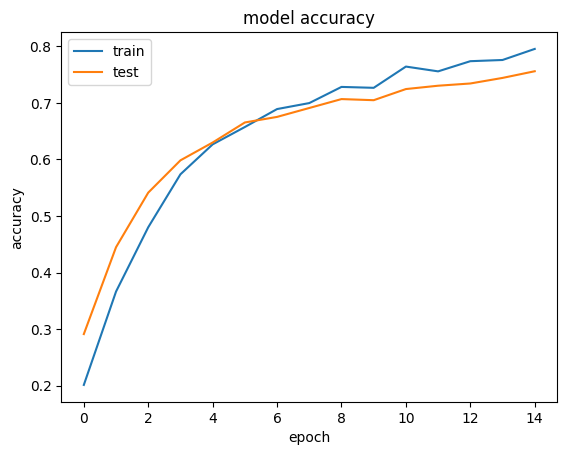

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

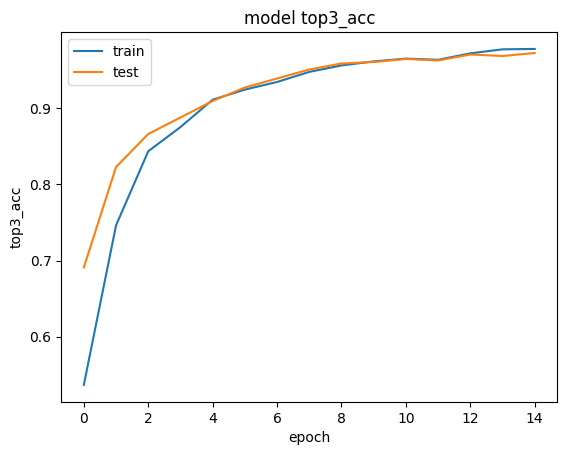

In [ ]:
plt.plot(history.history['top3_acc'])
plt.plot(history.history['val_top3_acc'])
plt.title('model top3_acc')
plt.ylabel('top3_acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

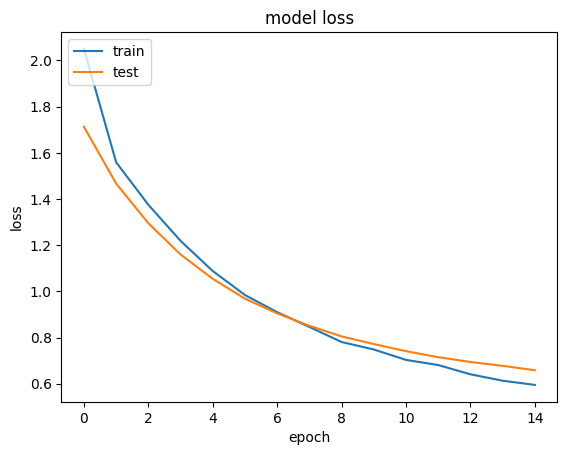

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Metric to report for each model

In [ ]:
# Acc@1: get the best val acc
max(history.history['val_accuracy'])

0.7559055089950562

In [ ]:
# Acc@3
max_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

history.history['val_top3_acc'][max_index]

0.9724409580230713

### Find the images that are misclassified

In [ ]:
# predict the class labels using the training model
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_class_indices = np.argmax(predictions, axis=1)


4/4 [==============================] - 3s 455ms/step


In [ ]:
# Get the true class indices and file paths from the test generator
true_class_indices = test_generator.classes
filepaths = test_generator.filepaths


In [ ]:
# Compare the predicted and true class indices to identify misclassified images
misclassified_indices = np.where(predicted_class_indices != true_class_indices)[0]
misclassified_filepaths = [filepaths[i] for i in misclassified_indices]


In [ ]:
num_misclassified_to_display = min(100, num_misclassified)
num_columns = 4
num_rows = num_misclassified_to_display // num_columns + int(num_misclassified_to_display % num_columns > 0)

label_names = {v: k for k, v in test_generator.class_indices.items()}

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
axes = axes.ravel()

for i, idx in enumerate(misclassified_indices[:num_misclassified_to_display]):
    img = plt.imread(filepaths[idx])
    true_label = label_names[true_class_indices[idx]]
    predicted_label = label_names[predicted_class_indices[idx]]

    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i].axis('off')

# Hide the remaining empty axes (if any)
for j in range(num_misclassified_to_display, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


# Model with Augmentation

In [ ]:
# Apply the MobileNetV2 pretrained model
pretrained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# define the model
def model_2():

    model = Sequential()
    model.add(pretrained_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6))
    model.add(Activation('softmax'))


    for layer in pretrained_model.layers:
        layer.trainable = False


    model.compile(loss='categorical_crossentropy', metrics=['accuracy', top3_acc],
                  optimizer=Adam(learning_rate=0.0001, decay=1e-6))

    return model

# Test function
model_2().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [ ]:
batch_size = 128
epochs = 15

# Do random training data augmentation with large batch size
# TODO: Augmentation / No Augmentation here
# TODO: Different backbones need different scaling
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data parameters
num_train_samples = 2019
num_test_samples = 508
# num_train_samples = 500
# num_test_samples = 500

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [ ]:
# Display the training images
# display_batch(train_generator, train_generator.class_indices)


In [ ]:
# Display the testing images
# display_batch(test_generator, train_generator.class_indices)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model = model_2()

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    steps_per_epoch=num_train_samples // batch_size,
    verbose=1
)

Epoch 1/15
15/15 [==============================] - 30s 2s/step - loss: 1.8394 - accuracy: 0.2697 - top3_acc: 0.6272 - val_loss: 1.4927 - val_accuracy: 0.4429 - val_top3_acc: 0.8150
Epoch 2/15
15/15 [==============================] - 26s 2s/step - loss: 1.4189 - accuracy: 0.4595 - top3_acc: 0.8144 - val_loss: 1.2471 - val_accuracy: 0.5748 - val_top3_acc: 0.8937
Epoch 3/15
15/15 [==============================] - 26s 2s/step - loss: 1.1957 - accuracy: 0.5621 - top3_acc: 0.8921 - val_loss: 1.0708 - val_accuracy: 0.6654 - val_top3_acc: 0.9252
Epoch 4/15
15/15 [==============================] - 26s 2s/step - loss: 1.0690 - accuracy: 0.6140 - top3_acc: 0.9038 - val_loss: 0.9566 - val_accuracy: 0.6909 - val_top3_acc: 0.9350
Epoch 5/15
15/15 [==============================] - 26s 2s/step - loss: 0.9180 - accuracy: 0.6690 - top3_acc: 0.9323 - val_loss: 0.8762 - val_accuracy: 0.7028 - val_top3_acc: 0.9469
Epoch 6/15
15/15 [==============================] - 26s 2s/step - loss: 0.8732 - accuracy:

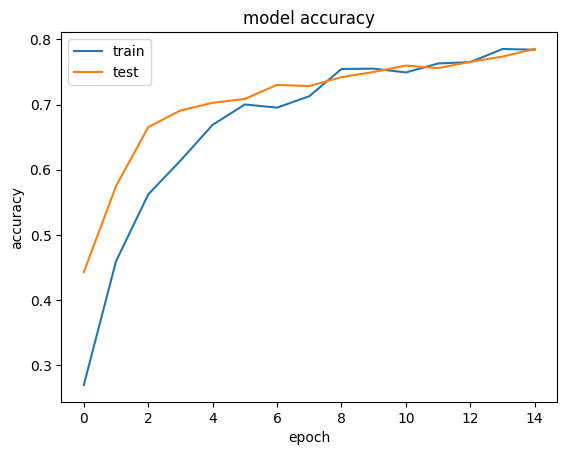

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

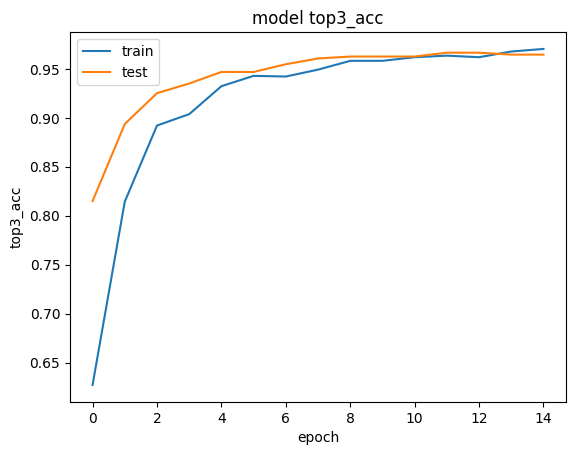

In [ ]:
plt.plot(history.history['top3_acc'])
plt.plot(history.history['val_top3_acc'])
plt.title('model top3_acc')
plt.ylabel('top3_acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

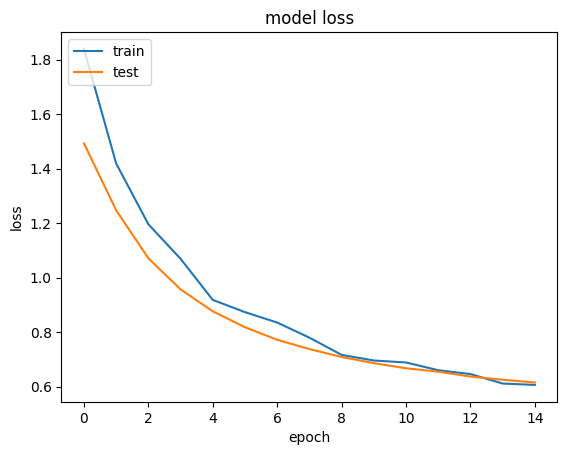

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Metric to report for each model

In [ ]:
# Acc@1: get the best val acc
max(history.history['val_accuracy'])

0.7854330539703369

In [ ]:
# Acc@3
max_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

history.history['val_top3_acc'][max_index]

0.9645669460296631

### Find the images that are misclassified

In [ ]:
# predict the class labels using the training model
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_class_indices = np.argmax(predictions, axis=1)


4/4 [==============================] - 3s 456ms/step


In [ ]:
# Get the true class indices and file paths from the test generator
true_class_indices = test_generator.classes
filepaths = test_generator.filepaths


In [ ]:
# Compare the predicted and true class indices to identify misclassified images
misclassified_indices = np.where(predicted_class_indices != true_class_indices)[0]
misclassified_filepaths = [filepaths[i] for i in misclassified_indices]


In [ ]:
# Display mismatched images
num_misclassified_to_display = min(100, num_misclassified)
num_columns = 4
num_rows = num_misclassified_to_display // num_columns + int(num_misclassified_to_display % num_columns > 0)

label_names = {v: k for k, v in test_generator.class_indices.items()}

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
axes = axes.ravel()

for i, idx in enumerate(misclassified_indices[:num_misclassified_to_display]):
    img = plt.imread(filepaths[idx])
    true_label = label_names[true_class_indices[idx]]
    predicted_label = label_names[predicted_class_indices[idx]]

    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i].axis('off')

# Hide the remaining empty axes (if any)
for j in range(num_misclassified_to_display, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


NameError: ignored